### Part 2 (start in class)

First let's fit our supernova synthetic data from last time using GPR.

- The key ingredient in getting a good GPR fit is the choice of the kernel and its parameters.
- Radial-basis function kernel (aka squared-exponential kernel) is a standard choice in the GPR world.
- But check out what's available in the `kernels` submodule of [sklearn.gaussian_process](https://scikit-learn.org/stable/modules/classes.html#module-sklearn.gaussian_process)
- Plot the expectation value of the fit as well as the resulting 1-$\sigma$ and 2-$\sigma$ contours.
- Interpret the results.

*Note*. To start with, feel free to tweak the hyperparameters manually. But, of course, a publication-quality result will require a cross-validation analysis.

The European Space Agency is considering new cosmology-related space mission. They ask you to figure out what science you can do with 10 times more measurement compared to what you have right now. That is: you want to clone your data. We've seen this earlier in the class, but now we can do much much better.
- Think about the pdf of these data in $z$.
- Using your GPR fit, generate a set of $\mu$ measurements that respects the statistical properties of the data you were given. 

### Part 3 (for the exam)

*(I know this assignment is longer and more convoluted, but we're getting towards the end of the class and it's important to draw connections between the different things we've done)*

We now have a suite of **data-driven** predictive models for our supernova dataset (from polynomials to GPR). That is: we can faithfully predict how a future redshift/distance measurement will look like given the current sample.

This is already great and these kind of tools are immensely useful in a variety of contexts (also involving a lot of money: suppose you want to predict how much a give financial asset will perform on tomorrow's stock market... You  might not really care about expressing the underlying financial model in simple terms, as long as your investments are profitable).

For the case of supernovae, however, we have do have physical theory which is $\Lambda$CDM. We can do a **parametric** fit (and hopehully by now the difference between "parametric" and "data driven" fit is clear in your head)

- First, refresh your cosmology and write down the predicted relationship between the distance module $\mu$ and the redshift $\sigma$. *Hint* I always forget these things, my to-go reference is [Hogg (2010)](https://arxiv.org/abs/astro-ph/9905116). The answer is:

$$\mu = 5 \log \left( \frac{c/H_0} {10 {\rm pc}}(1+z)\int_0^z \frac{dz'}{\sqrt{\Omega_m (1+z^3)+\Omega_\Lambda}} \right) $$

- Assuming a flat Universe,  we have a parametric non-linear model for $\mu(z)$ that depends on two parameters, the Hubble constant $H_0$ and the matter content of the Universe $\Omega_m$
- It's a very non-linear model. Fit it to the data, however you want to do it, using tecniques we've seen throughout the course. Some ideas:
    - Set up a Bayesian framework and use MCMC. 
    - Set up a fully-connected neural network (see end of the class).

- What are the measured value of $H_0$ and $\Omega_m$. What's they errors? Are they correlated?
- How would a model without dark energy (i.e. $\Omega_m=1$) perform? Do these data contain evidence of dark energy? (Hint: this is a model selection problem!)

In [1]:
from astroML.datasets import generate_mu_z
import numpy as np
from matplotlib import pyplot as plt

from sklearn.gaussian_process import GaussianProcessRegressor, kernels
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KernelDensity

from astropy.cosmology import LambdaCDM
import scipy.stats as scistats
import corner
import dynesty 
from dynesty import utils as dyfunc

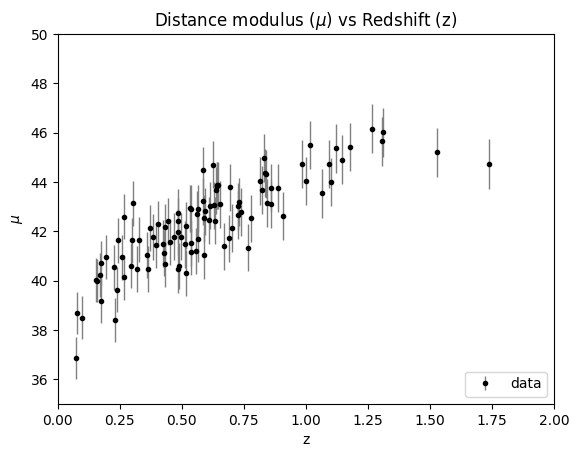

In [2]:
z_sample, mu_sample, dmu = generate_mu_z(100, random_state=1234) 
plt.errorbar(z_sample, mu_sample, dmu, fmt='.k', ecolor='gray', lw=1,label='data')
plt.xlabel("z")
plt.ylabel(r"$\mu$")
plt.legend(loc='lower right')
plt.xlim(0,2)
plt.ylim(35,50)
plt.title(r"Distance modulus ($\mu$) vs Redshift (z)")
plt.show()

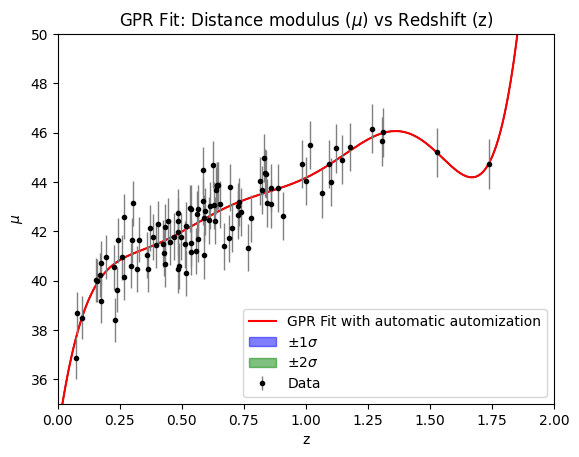

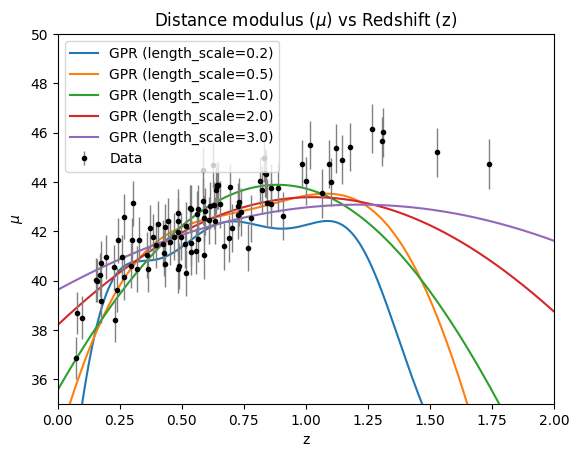

mean alpha: 0.8984692073361772


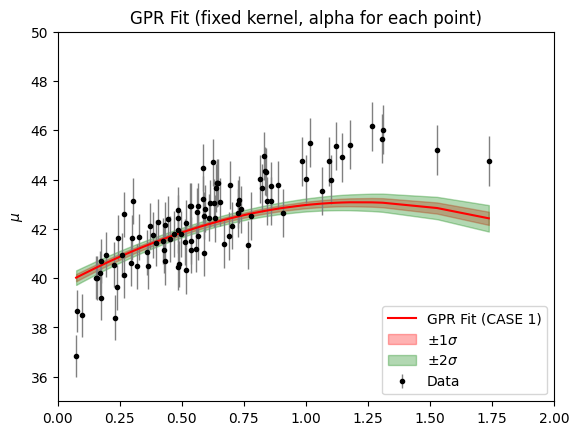

In [3]:
# > FIT USING GPR (Gaussian Process Regression)
# CASE 0: automatic optimization of kernel parameters, alpha assumed constant or estimated
z_sample = z_sample.reshape(-1, 1)
z_plot = np.linspace(0, 2, 1000).reshape(-1, 1)
gp = GaussianProcessRegressor()
gp.fit(z_sample, mu_sample)
y_pred, dy_pred = gp.predict(z_plot, return_std=True)

plt.plot(z_plot, y_pred, color='red', label='GPR Fit with automatic automization')
plt.errorbar(z_sample, mu_sample, dmu, fmt='.k', ecolor='gray', lw=1, label='Data')
plt.fill_between(z_plot.ravel(), y_pred - dy_pred, y_pred + dy_pred, color='blue', alpha=0.5, label=r'$\pm 1\sigma$') # 1 sigma bandwidth
plt.fill_between(z_plot.ravel(), y_pred - 2*dy_pred, y_pred + 2*dy_pred, color='green', alpha=0.5, label=r'$\pm 2\sigma$') # 2 sigma bandwidth
plt.xlabel("z")
plt.ylabel(r"$\mu$")
plt.legend(loc='lower right')
plt.xlim(0, 2)
plt.ylim(35, 50)
plt.title(r"GPR Fit: Distance modulus ($\mu$) vs Redshift (z)")
plt.show()


# CASE 1: chosen kernel and uncertainties - RBF kernel (Radial Basis Function = squared exponential = Gaussian kernel) 
# Length scale (LS): distance beyond which points become weakly correlated
# Small LS  → the model follows the data more closely (less smoothing)
# Large LS  → the model is smoother (more generalization)
  
lengths = [0.2, 0.5, 1.0, 2.0, 3.0] # fixed length scale

for l in lengths:
    kernel = kernels.RBF(length_scale=l, length_scale_bounds=(l, l))
    gp = GaussianProcessRegressor(kernel=kernel, alpha=dmu**2, random_state=0, optimizer=None)
    gp.fit(z_sample, mu_sample)
    z_plot = np.linspace(0, 2, 1000).reshape(-1, 1)
    f_pred, f_std = gp.predict(z_plot, return_std=True)

    plt.plot(z_plot, f_pred, label=f'GPR (length_scale={l})')

plt.errorbar(z_sample, mu_sample, dmu, fmt='.k', ecolor='gray', lw=1,label='Data')
plt.xlabel("z")
plt.ylabel(r"$\mu$")
plt.legend(loc='lower right')
plt.xlim(0,2)
plt.ylim(35,50)
plt.title(r"Distance modulus ($\mu$) vs Redshift (z)")
plt.legend()
plt.show()


kernel1 = kernels.RBF(length_scale=3.0, length_scale_bounds=(3.0, 3.0))
gp1 = GaussianProcessRegressor(kernel=kernel1, alpha=dmu** 2, random_state=0, optimizer=None) # alpha = noise variance in the observed data (for each point)
gp1.fit(z_sample, mu_sample)
f1, f1_err = gp1.predict(z_sample, return_std=True)

alphas = np.mean(gp1.get_params()['alpha'])
alpha = np.mean(alphas)
print(f"mean alpha: {alpha}")

z_flat = z_sample.ravel() # flat -> 1D
f1_flat = f1.ravel() 
f1_err_flat = f1_err.ravel()

idx_sort = np.argsort(z_flat)  # sort simulated data indeces in the right order for the fit 
z_sorted = z_flat[idx_sort]
f1_sorted = f1_flat[idx_sort] 
f1_err_sorted = f1_err_flat[idx_sort]

plt.errorbar(z_sample, mu_sample, dmu, fmt='.k', ecolor='gray', lw=1, label='Data')
plt.plot(z_sorted, f1_sorted, 'r-', label='GPR Fit (CASE 1)')
plt.fill_between(z_sorted, f1_sorted - f1_err_sorted, f1_sorted + f1_err_sorted, color='red', alpha=0.3, label=r'$\pm 1\sigma$')
plt.fill_between(z_sorted, f1_sorted - 2*f1_err_sorted, f1_sorted + 2*f1_err_sorted, color='green', alpha=0.3, label=r'$\pm 2\sigma$')

plt.ylabel(r"$\mu$")
plt.legend(loc='lower right')
plt.xlim(0, 2)
plt.ylim(35, 50)
plt.title("GPR Fit (fixed kernel, alpha for each point)")
plt.show()

Best length scale: {'kernel__k1__constant_value': 20.0, 'kernel__k2__length_scale': 3.0}
Best model: GaussianProcessRegressor(alpha=np.float64(0.8984692073361772),
                         kernel=4.47**2 * RBF(length_scale=3), optimizer=None)


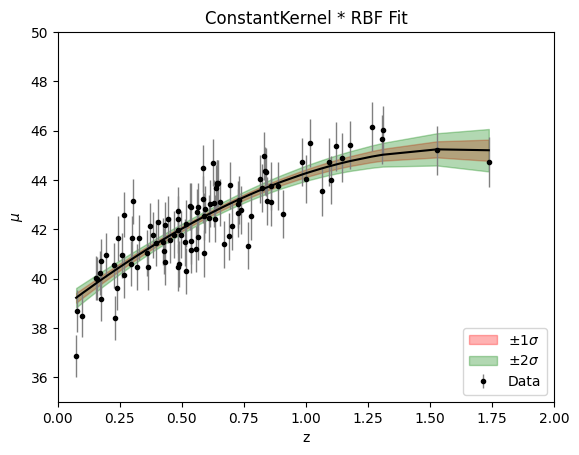

In [4]:
# CASE 2: ConstantKernel * RBF
# RBF determines how similar two points are based on their distance
# ConstantKernel is a global multiplication factor -> it changes the vertical amplitude

# Search for best lenght scale - GPR best estimator
kernel = kernels.ConstantKernel(1.0, (1e-1, 1e4)) * kernels.RBF(1.0, (1e-2, 1e3))
param_grid = {
    "kernel__k1__constant_value": [0.1, 0.3, 0.5, 1.0, 10.0, 20.0], # scikit-learn sintax
    "kernel__k2__length_scale": [1.0, 3.0, 5.0, 10.0, 15.0, 20.0]   # scikit-learn sintax
}
alpha_mean = np.mean(dmu**2)
gp = GaussianProcessRegressor(kernel=kernel, alpha=alpha_mean, optimizer=None)
search = GridSearchCV(gp, param_grid, cv=5)
search.fit(z_sample, mu_sample)

print("Best length scale:", search.best_params_) # between the grid given -> starting point for ulterior optimization
print("Best model:", search.best_estimator_) 

# Best fit
gp2 = search.best_estimator_
gp2.alpha = dmu**2  
gp2.fit(z_sample, mu_sample)

mu_fit, sigma = gp2.predict(z_sample, return_std=True)

plt.errorbar(z_sample, mu_sample, dmu, fmt='.k', ecolor='gray', lw=1, label='Data')

z_flat = z_sample.ravel()
mu_fit_flat = mu_fit.ravel()
sigma_flat = sigma.ravel()

idx_sort = np.argsort(z_flat)
z_sorted = z_flat[idx_sort]
mu_fit_sorted = mu_fit_flat[idx_sort]
sigma_sorted = sigma_flat[idx_sort]

plt.plot(z_sorted, mu_fit_sorted, '-k' )
plt.fill_between(z_sorted, mu_fit_sorted - sigma_sorted, mu_fit_sorted + sigma_sorted, alpha=0.3, color='red', label=r'$\pm 1\sigma$')
plt.fill_between(z_sorted, mu_fit_sorted - 2* sigma_sorted, mu_fit_sorted + 2* sigma_sorted, alpha=0.3, color='green', label=r'$\pm 2\sigma$')

plt.xlabel("z")
plt.ylabel(r"$\mu$")
plt.legend(loc='lower right')
plt.xlim(0,2)
plt.ylim(35,50)
plt.title("ConstantKernel * RBF Fit")
plt.show()

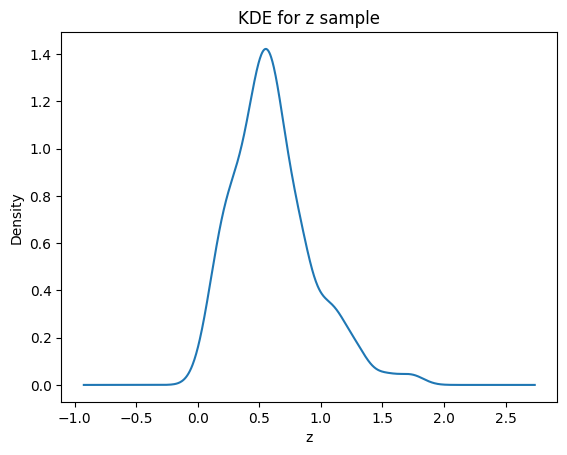

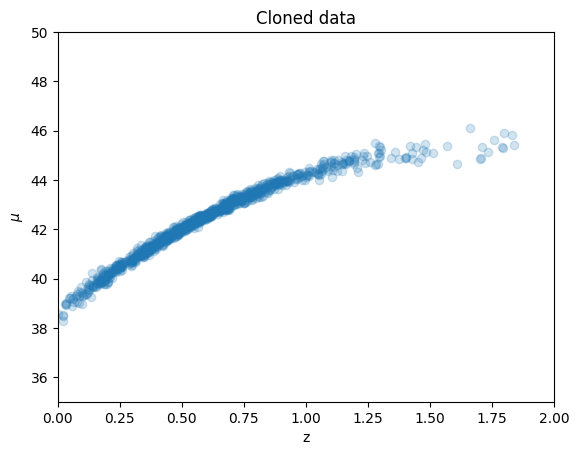

In [5]:
# > Use the GPR fit to clone the data 

# Estimate with KDE z density distribution 
KDE = KernelDensity(kernel='gaussian', bandwidth=0.1) 
KDE.fit(z_sample) 

z_plot = np.linspace(z_sample.min() - 1, z_sample.max() + 1, 1000).reshape(-1, 1)
log_dens = KDE.score_samples(z_plot)
dens = np.exp(log_dens)

plt.title("KDE for z sample")
plt.plot(z_plot[:, 0], dens)
plt.xlabel('z')
plt.ylabel('Density')
plt.show()

# Cloning data from the z-density
N = 1000
new_z = KDE.sample(N)

new_mu=[]
for z in new_z.ravel():    
    mu_fit, sigma = gp2.predict([[z]], return_std=True)
    new_mu.append(np.random.normal(loc=mu_fit,scale=sigma)) # simulate a realistic value of mu
    
    
plt.scatter(new_z, new_mu, alpha=0.2)

plt.xlabel("z")
plt.ylabel(r"$\mu$")
plt.xlim(0,2)
plt.ylim(35,50)
plt.title("Cloned data")
plt.show()


>> Nested Sampling for LCDM Model


1533it [00:18, 82.97it/s, +500 | bound: 0 | nc: 1 | ncall: 11178 | eff(%): 19.039 | loglstar:   -inf < -132.814 <    inf | logz: -134.993 +/-  0.040 | dlogz:  0.001 >  0.500]


Summary
nlive: 500
niter: 1533
ncall: 10678
eff(%): 19.039
logz: -134.993 +/-  0.110
None


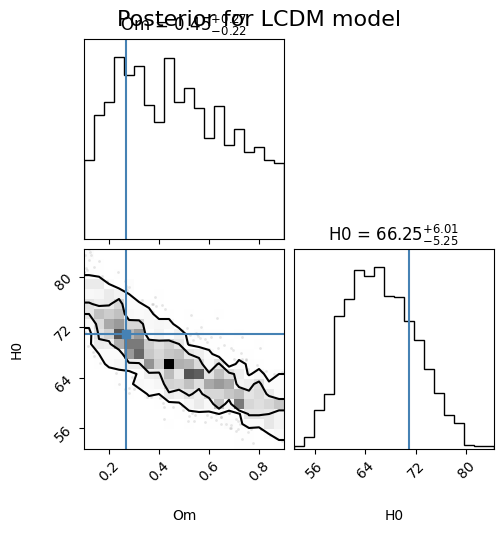

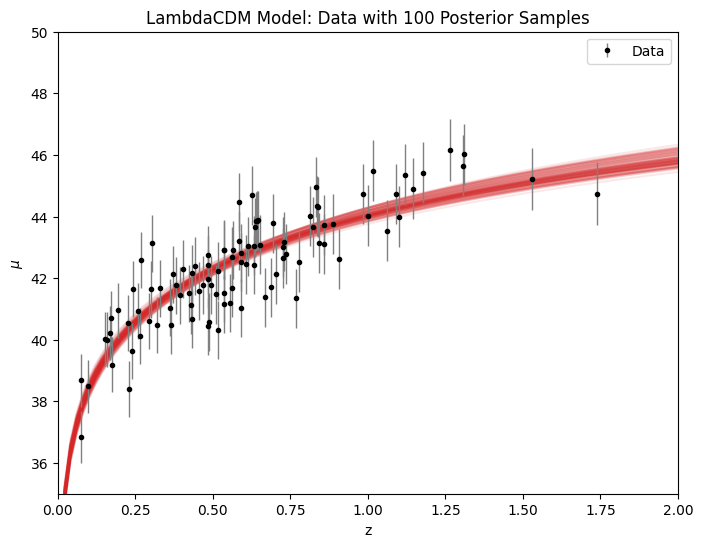


 LCDM MODEL: 
Om = 0.465 +/- 0.212
H0 = 66.586 +/- 5.425
Log Evidence: -134.993 +/- 0.110


In [6]:
# > PART 3: Lambda Cold Dark Matter model study - parametric fit with NESTED SAMPLING

# Predicted relationship between the distance module and the redshift
# H0 = Hubble constant || Om = OMEGAm = total matter density | Ode0 = OMEGAlambda = dark energy density
# HYPOTHESIS: flat universe, curvature density OMEGAk = 0 -> Om + Ol = 1

# THEORETICAL MODEL 
def generativemodel_LCDM(z, H0, Om):
    z_flat = z.ravel() # flat NumPy array for astropy.cosmology functions
    
    # Internal checks for astropy's LambdaCDM (wider bounds, main ones are in the prior)
    if not (0 < Om < 2.0 and 0 < H0 < 200): 
        return np.full_like(z_flat, np.inf) # so that logLikelihood is 0 for non-physical values

    try: # handle potential errors (exceptions launched by LambdaCDM, if H0 and Om values are not valid)
        cosmo_tmp = LambdaCDM(H0=H0, Om0=Om, Ode0=1-Om) # Om0: density parameter for matter || Ode0: density parameter for dark energy 
        distmod_value = cosmo_tmp.distmod(z_flat).value # distmod() returns astropy.units.Quantity -> we want an array: .value
        
        # Check for non-finite values that astropy might return for extreme parameters values
        if np.any(np.isnan(distmod_value)) or np.any(np.isinf(distmod_value)):
            return np.full_like(z_flat, np.inf)
        
        return distmod_value  # all values are valid
    
    except Exception as e:
        return np.full_like(z_flat, np.inf) # return inf 

# LOG-LIKELIHOOD for LCDM  
def LOGlikelihood_LCDM(theta):
    Om, H0 = theta

    if not (0.1 < Om < 0.9 and 50 < H0 < 100): # check if values are valid in a physical sense
        return -np.inf

    mu_model = generativemodel_LCDM(z_sample, H0, Om)

    if np.any(np.isnan(mu_model)) or np.any(np.isinf(mu_model)): # check if values are valid
        return -np.inf

    return np.sum(scistats.norm.logpdf(mu_sample.ravel(), loc=mu_model, scale=dmu.ravel()))

# PRIOR TRANSFORM for LCDM
# This function maps from the unit hypercube [0, 1]^ndim to the physical parameter space (uniform priors -> linear transformation)
# u -> 2 values: u[0] and u[1] between 0 and 1 

def prior_transform_LCDM(u): 
    # Uniform prior from 0.1 to 0.9
    Om_min, Om_max = 0.1, 0.9
    Om = u[0] * (Om_max - Om_min) + Om_min
    
    # Uniform prior from 50 to 100
    H0_min, H0_max = 50, 100
    H0 = u[1] * (H0_max - H0_min) + H0_min
    
    return [Om, H0]

# > Nested Sampling for LambdaCDM Model
ndim_LCDM = 2 
print("\n>> Nested Sampling for LCDM Model")

sampler_LCDM = dynesty.NestedSampler(LOGlikelihood_LCDM, prior_transform_LCDM, ndim_LCDM, 
                                     nlive=500, 
                                     bound='multi', # multi-ellipsoidal bounding -> adapt to the shape of the posterior more accurately
                                     sample='rwalk') # better exploration of complex posteriors

sampler_LCDM.run_nested(dlogz=0.5, print_progress=True) # dlogz: stopping criterion -> when the estimated remaining log-evidence is less than dlogz
results_LCDM = sampler_LCDM.results
print(results_LCDM.summary())

# Parameters and weights 
samples_LCDM = results_LCDM.samples
weights_LCDM = np.exp(results_LCDM.logwt - results_LCDM.logz[-1]) # convert log_weights and normalise
 
# Resample weighted samples to get unweighted samples for corner plot
flat_samples_LCDM = dyfunc.resample_equal(samples_LCDM, weights_LCDM)

fig = corner.corner(
    flat_samples_LCDM, labels=["Om", "H0"], levels=[0.68, 0.95], show_titles=True,
    truths=[0.27, 71] # true values for comparison if known
)
fig.suptitle("Posterior for LCDM model", fontsize=16)
plt.show()

# Plot fit with different parameters values extracted from the posterior
zlin = np.linspace(0, 2, 100)[1:]
plt.figure(figsize=(8, 6))

plot_indices = np.random.choice(len(flat_samples_LCDM), size=100, replace=False) # replace=False for unique indices (not repeted)
for i in plot_indices:
    Om_s, H0_s = flat_samples_LCDM[i]
    plt.plot(zlin, generativemodel_LCDM(zlin, H0_s, Om_s), c='C3', alpha=0.1)

plt.errorbar(z_sample.ravel(), mu_sample.ravel(), dmu.ravel(), fmt='.k', ecolor='gray', lw=1, label='Data')
plt.xlabel("z")
plt.ylabel(r"$\mu$")
plt.xlim(0,2)
plt.ylim(35,50)
plt.title("LambdaCDM Model: Data with 100 Posterior Samples")
plt.legend()
plt.show()

# Mean and standard deviation of parameters for LCDM
om_lcdm_mean = np.mean(flat_samples_LCDM[:, 0])
h0_lcdm_mean = np.mean(flat_samples_LCDM[:, 1])
om_lcdm_err = np.std(flat_samples_LCDM[:, 0])
h0_lcdm_err = np.std(flat_samples_LCDM[:, 1])

print("\n LCDM MODEL: ")
print(f"Om = {om_lcdm_mean:.3f} +/- {om_lcdm_err:.3f}")
print(f"H0 = {h0_lcdm_mean:.3f} +/- {h0_lcdm_err:.3f}")
print(f"Log Evidence: {results_LCDM.logz[-1]:.3f} +/- {results_LCDM.logzerr[-1]:.3f}")


>> Nested Sampling for MATTER-ONLY MODEL


745it [00:07, 94.83it/s, +250 | bound: 0 | nc: 1 | ncall: 5373 | eff(%): 19.422 | loglstar:   -inf < -133.530 <    inf | logz: -135.587 +/-  0.050 | dlogz:  0.002 >  0.500]


Summary
nlive: 250
niter: 745
ncall: 5123
eff(%): 19.422
logz: -135.587 +/-  0.145
None


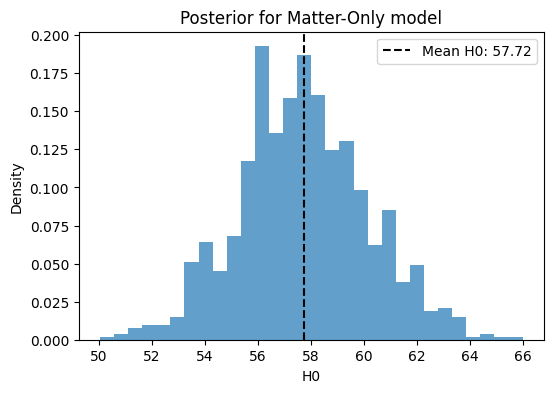

Matter-Only Model: 
H0 = 57.725 +/- 2.443
Log Evidence: -135.587 +/- 0.145


In [7]:
# > MODEL 2: Matter-Only Model -> Omega_Lambda = 0 + flat universe --> Omega_M = 1
# Remains only one parameter: H0

# MODIFIED THEORETICAL MODEL  
def generativemodel_MO(z, H0):
    z_flat = z.ravel()
    
    if not (0 < H0 < 200): # Wider internal bounds for astropy
        return np.full_like(z_flat, np.inf)

    try:
        cosmo_tmp = LambdaCDM(H0=H0, Om0=1.0, Ode0=0.0) # Om0=1 and Ode0=0
        distmod_value = cosmo_tmp.distmod(z_flat).value

        if np.any(np.isnan(distmod_value)) or np.any(np.isinf(distmod_value)):
            return np.full_like(z_flat, np.inf)
        
        return distmod_value
    
    except Exception as e:
        return np.full_like(z_flat, np.inf)

# MODIFIED LOG-LIKELIHOOD 
def LOGlikelihood_MO(theta):
    H0 = theta[0] 

    if not (50 < H0 < 100): 
        return -np.inf

    mu_model = generativemodel_MO(z_sample.ravel(), H0)

    if np.any(np.isnan(mu_model)) or np.any(np.isinf(mu_model)):
        return -np.inf

    return np.sum(scistats.norm.logpdf(mu_sample.ravel(), loc=mu_model, scale=dmu.ravel()))

# MODIFIED PRIOR TRANSFORM
def prior_transform_MO(u): # u = u[0]

    # H0: Uniform prior from 50 to 100
    H0_min, H0_max = 50, 100
    H0 = u[0] * (H0_max - H0_min) + H0_min
    return [H0]

# > Nested Sampling for matter-only model 
ndim_MO = 1 
print("\n>> Nested Sampling for MATTER-ONLY MODEL")

sampler_MO = dynesty.NestedSampler(LOGlikelihood_MO, prior_transform_MO, ndim_MO,
                                         nlive=250, # as it's simpler model
                                         bound='single', # sufficient for 1D
                                         sample='rwalk')

sampler_MO.run_nested(dlogz=0.5, print_progress=True)
results_MO = sampler_MO.results
print(results_MO.summary())

samples_MO = results_MO.samples
weights_MO = np.exp(results_MO.logwt - results_MO.logz[-1])
flat_samples_MO = dyfunc.resample_equal(samples_MO, weights_MO)

# Corner plot for Matter-Only (1D -> histogram)
plt.figure(figsize=(6, 4))
plt.hist(flat_samples_MO[:, 0], bins=30, density=True, alpha=0.7)
plt.xlabel("H0")
plt.ylabel("Density")
plt.title("Posterior for Matter-Only model")
plt.axvline(np.mean(flat_samples_MO[:, 0]), color='black', linestyle='dashed', label=f'Mean H0: {np.mean(flat_samples_MO[:, 0]):.2f}') # mean value
plt.legend()
plt.show()

# Median and standard deviation of H0
h0_mo_mean = np.mean(flat_samples_MO[:, 0])
h0_mo_err = np.std(flat_samples_MO[:, 0])

print("Matter-Only Model: ")
print(f"H0 = {h0_mo_mean:.3f} +/- {h0_mo_err:.3f}")
print(f"Log Evidence: {results_MO.logz[-1]:.3f} +/- {results_MO.logzerr[-1]:.3f}")

In [8]:
# Model COMPARISON using Bayesian evidence
logz_LCDM = results_LCDM.logz[-1]
logz_MO = results_MO.logz[-1]

print(f"\nLog Evidence (LCDM): {logz_LCDM:.3f}")
print(f"Log Evidence (Matter-Only): {logz_MO:.3f}")

# Bayes Factor K = P(D|M_LCDM) / P(D|M_MO)
logB = logz_LCDM - logz_MO
B = np.exp(logB) 

print(f"Log Bayes Factor (LCDM vs Matter-Only): {logB:.3f}")
print(f"Bayes Factor (LCDM vs Matter-Only): {B:.2e}")

# Interpretation of Bayes Factor (Jeffreys' scale)
if logB < 0: 
    print("MATTER ONLY model is favoured !")
else: 
    print("LCDM is favoured !")
    
if abs(logB) < 1:
    evidence = "Inconclusive"
elif abs(logB) < 2.5:
    evidence = "Weak evidence"
elif abs(logB) < 5:
    evidence = "Moderate evidence"
else:
    evidence = "Strong evidence"

print(evidence)

# Used only 100 simulated data points, which introduces a lot of uncertainty


Log Evidence (LCDM): -134.993
Log Evidence (Matter-Only): -135.587
Log Bayes Factor (LCDM vs Matter-Only): 0.594
Bayes Factor (LCDM vs Matter-Only): 1.81e+00
LCDM is favoured !
Inconclusive
